In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow.keras.layers import TextVectorization 
from tensorflow.keras.utils import get_file 

In [2]:
# Load the dataset 
path_to_file = get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt') 
text = open(path_to_file, 'rb').read().decode(encoding='utf-8') 

# Preview the dataset 
print(text[:1000]) 

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [14]:
# Preprocess the dataset 
vocab_size = 10000 
seq_length = 50

# Adapt TextVectorization to full text 
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int') 
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1) 
vectorizer.adapt(text_ds) 

# Vectorize the text 
vectorized_text = vectorizer([text])[0] 
print("Vectorized text shape:", vectorized_text.shape) 
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10]) 


Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]


Create input and target sequences

In [15]:
def create_sequences(text, seq_length): 
    input_seqs = [] 
    target_seqs = [] 
    for i in range(len(text) - seq_length): 
        input_seq = text[i:i + seq_length] 
        target_seq = text[i + 1:i + seq_length + 1] 
        input_seqs.append(input_seq) 
        target_seqs.append(target_seq) 
    return np.array(input_seqs), np.array(target_seqs) 

# Generate sequences 
X, Y = create_sequences(vectorized_text.numpy(), seq_length) 

# Check if sequences are correctly generated 
print("Number of sequences generated:", len(X)) 
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated") 

# Check if X and Y are not empty 
assert X.size > 0, "Input data X is empty" 
assert Y.size > 0, "Target data Y is empty" 
X = tf.convert_to_tensor(X) 
Y = tf.convert_to_tensor(Y) 
print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape)

Number of sequences generated: 202596
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79]
Shape of X: (202596, 50)
Shape of Y: (202596, 50)


Build the transformer model

In [5]:
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(Model):  # Model is now properly imported
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.dense = Dense(vocab_size)

    def positional_encoding(self, seq_length, embed_dim):
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :seq_len, :]
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)  # Pass training argument correctly
        output = self.dense(x)
        return output

In [6]:
# Hyperparameters 
embed_dim = 256 
num_heads = 4 
ff_dim = 512 
num_layers = 4 

# Build the Transformer model 
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

# Compile the model 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Summary of the model 
model.summary()

Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2560000   
                                                                 
 transformer_block (Transfor  multiple                 1315840   
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  multiple                 1315840   
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  multiple                 1315840   
 ormerBlock)                                                     
                                                                 
 transformer_block_3 (Transf  multiple                 1315840   
 ormerBlock)                                     

Train the transfoprmer model

In [7]:
print(tf.__version__)

2.10.0


Epoch 1/20
6330/6330 [==============================] - 382s 60ms/step - loss: 11.9525
Epoch 2/20
6330/6330 [==============================] - 380s 60ms/step - loss: 12.1876
Epoch 3/20
6330/6330 [==============================] - 379s 60ms/step - loss: 11.7522
Epoch 4/20
6330/6330 [==============================] - 375s 59ms/step - loss: 11.0074
Epoch 5/20
6330/6330 [==============================] - 368s 58ms/step - loss: 10.6423
Epoch 6/20
6330/6330 [==============================] - 368s 58ms/step - loss: 10.7965
Epoch 7/20
6330/6330 [==============================] - 369s 58ms/step - loss: 9.7971
Epoch 8/20
6330/6330 [==============================] - 369s 58ms/step - loss: 9.2107
Epoch 9/20
6330/6330 [==============================] - 369s 58ms/step - loss: 9.2107
Epoch 10/20
6330/6330 [==============================] - 369s 58ms/step - loss: 9.2107


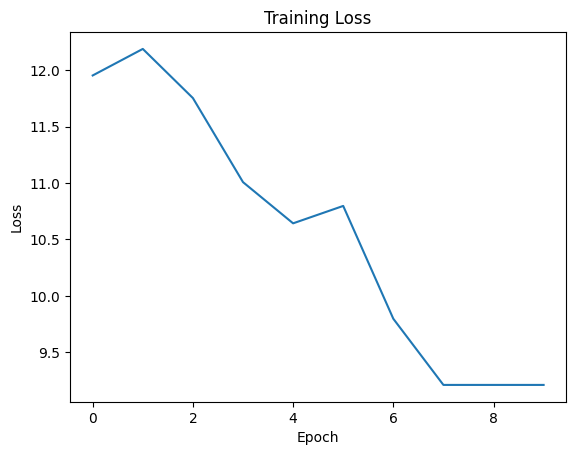

In [8]:
# Import necessary libraries for training visualization
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on the full input and target sequences
history = model.fit(X, Y, epochs=20, batch_size=32, callbacks=[early_stopping])

# Plot training loss to monitor model performance over epochs
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    # Convert the start string to a vectorized format
    input_eval = vectorizer([start_string]).numpy()

    # Ensure the input length matches the model's sequence length
    if input_eval.shape[1] < seq_length:
        # Pad if shorter
        padding = np.zeros((1, seq_length - input_eval.shape[1]))
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
        # Truncate if longer
        input_eval = input_eval[:, -seq_length:]

    input_eval = tf.convert_to_tensor(input_eval, dtype=tf.int32)

    # List to store generated tokens
    text_generated = []

    for _ in range(num_generate):
        # Predict the next token
        predictions = model(input_eval)  # Output logits

        # Reshape logits to [batch_size, vocab_size]
        predictions = predictions[0]

        # Apply temperature
        predictions = predictions / temperature
        predictions = tf.nn.softmax(predictions)  # Normalize logits

        # Sample from the probability distribution
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Add the predicted token, maintaining the sequence length
        input_eval = tf.concat(
            [input_eval[:, 1:], tf.expand_dims([predicted_id], axis=0)], axis=1
        )

        # Append the generated token to the text
        vocab = vectorizer.get_vocabulary()
        if predicted_id < len(vocab):
            text_generated.append(vocab[predicted_id])
        else:
            text_generated.append('<UNK>')  # Handle out-of-vocabulary tokens

    return start_string + ' ' + ' '.join(text_generated)

# Example usage
start_string = "i am in my house"
generated_text = generate_text(model, start_string, num_generate=100, temperature=0.7)
print(generated_text)


i am in my house heal pieces sleeves thieves supposed unity battles traditional sincerely opposing ballads marted monthly unsworn witch ominous proves thoughtfor affairs revel couple biting tossing wretchedst thousandfold watching breathed stirring coffin cures rents riggd sheephook spray uttermost otherwise putteron waked western swift prop antipodes harms southward affected sins rose soaking sinfully seeking dighton mercy plucked runnst hercules shortst moral prophecies viewd received which deliberate burning sweet denial eternity tedious seal camp perfumed both nosegays vagabond careful mens scabs angle raised unstable lourd bower seamark commission serve laying repeals sententious wisdoms obstinate person revenues hay befell recanting payment defy prophesy rumour cur you


: 